# Topic Discovery in Scholarly Articles: Unsupervised Learning with K-Means



In [ ]:
try:
    from google.colab import drive
    running_colab = True
except:
    print("Not Running on Google Colab!")
    running_colab = False

if running_colab:
    drive.mount('/content/drive')
    %cd /content/drive/My Drive/Colab Notebooks

## Data : Sample of 5k ArXiv Paper Abstracts
Dataset of 5k paper abstracts uploaded to the online scholarly article repository [arXiv](https://arxiv.org/). Each row corresponds to a paper and contains the following fields:

1. `id` : Unique ID assigned to each submission on arXiv formatted as `YYMM.NNNNN` (YY - two characters for year, MM - two characters for month, NNNNN - upto 5 characters for serial number of submission). Older submissions have the following format: `subject/YYMMNNN` e.g. `cs/0511035`

2. `submitter`: Name of the user uploading the paper

3. `authors`: Names of the authors

4. `comments`: Comments made by the submitter about the paper during submission

5. `journal-ref`: Bibliographic reference to the article if it has been published in a journal

6. `doi`: Digital Object Identifier(s) of the article

7. `abstract`: Contents of the paper's abstract

8. `report-no`: Publication number assigned by the author's institution

9. `version`: List of versions of the paper on arXiv

Leveraging Unsupervised Learning to Identify Prevalent Subjects in Research Paper Abstracts with K-Means Clustering
The implemented pipeline for the project comprises the following stages:
* A. **Text Processing**:  The abstracts were cleaned and preprocessed using the nltk package to prepare the text data for analysis. This step included tokenization, stopword removal, and stemming/lemmatization for effective feature extraction.
* B. **Feature Construction**: The preprocessed text was converted into numerical feature vectors using techniques such as TF-IDF (Term Frequency-Inverse Document Frequency) to capture the importance of terms in the dataset.
* C. **Clustering**: K-Means clustering was applied to group the abstracts into distinct clusters, identifying prevalent subjects and patterns within the dataset.
* D. **Visualization**: The resulting clusters were visualized using tools like WordClouds and 2D projections, providing insights into the topics and their distribution across the dataset.



In [ ]:
!pip install ipympl


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import sklearn
import re
import string
%matplotlib widget

In [ ]:
nltk.download("stopwords")
nltk.download("wordnet")
nltk.download("averaged_perceptron_tagger_eng")
nltk.download("punkt_tab")
nltk.download("punkt")
nltk.download("averaged_perceptron_tagger")

lemmatizer = nltk.stem.wordnet.WordNetLemmatizer()
stopwords = nltk.corpus.stopwords.words("english")



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


<a id='stop_words'></a>

##Text Processing

The text processing stage focuses on preparing paper abstracts for analysis by implementing a series of preprocessing functions with the following criteria:

1. All tokens are in lower case
2. Order of tokens is preserved
3. Tokens are lemmatized
4. Punctuations are stripped from all tokens
5. URLs are completely removed
6. Inline LaTeX equations are removed
7. LaTeX Text Decorations are removed

##Cleaning Text I.

In [ ]:
# Converting part of speech tag from nltk.pos_tag to word net compatible format
# Simple mapping based on first letter of return tag to make grading consistent
# Everything else will be considered noun 'n'
posMapping = {
# "First_Letter by nltk.pos_tag":"POS_for_lemmatizer"
    "N":'n',
    "V":'v',
    "J":'a',
    "R":'r'
}

def process(text, lemmatizer=nltk.WordNetLemmatizer()):

    """
    Normalizes case and handles punctuation

    Parameters
    ----------
    text: str:
        raw text
    lemmatizer: nltk.WordNetLemmatizer()
        an instance of a class implementing the lemmatize() method
        (the default argument is of type nltk.stem.wordnet.WordNetLemmatizer)

    Returns
    -------
    list(str)
        tokenized text
    """

    regex=r'http[s]?://\S+|www\.\S+'
    text = re.sub(r'\$.*?\$', '', text)
    text = re.sub(r'\\[a-zA-Z]+\{(.*?)\}', r'\1', text)
    text=re.sub(regex,'',text)
    text=text.lower()

    text = re.sub(r"'s\b", '', text)
    text = re.sub(r"'", '', text)
    regex2 = r'[!"#$%&\'()*+,\-./:;<=>?@[\\\]^_`{|}~]'
    text = re.sub(regex2, ' ', text)
    tokens = nltk.word_tokenize(text)
    tags = nltk.pos_tag(tokens)


    lemma = []

    for word, pos_tg in tags:
      pos_char = pos_tg[0]
      pos_mapped = posMapping.get(pos_char, 'n')

      try:
          lemma_word = lemmatizer.lemmatize(word, pos=pos_mapped)
          lemma.append(lemma_word)
      except Exception as e:
          continue


    return lemma




You should test your `process()` function at the bottom of the following code cell. We have provided portions of a few abstracts from the data as inputs to test with in order to get you started:

In [ ]:
input_1 = " Two-dimensional (2D) layered transition metal dichalcogenides \
              (TMDs) have\nemerged as promising materials for electronic, optoelectronic,\
               and valleytronic\napplications."

print(process(input_1))
# ['two', 'dimensional', '2d', 'layered', 'transition', 'metal', 'dichalcogenides',
#  'tmds', 'have', 'emerge', 'a', 'promising', 'material', 'for', 'electronic',
#  'optoelectronic', 'and', 'valleytronic', 'application']

input_2 = "  We solved analytically viscous two-dimensional (2D) fluid equations\
               for\naccretion and outflows in spherical polar coordinates ($r, \\theta, \\phi$)\
               and\nobtained explicitly flow variables in $r-$ and $\\theta -$directions\
               around\nblack holes (BHs)."

print(process(input_2))
# ['we', 'solve', 'analytically', 'viscous', 'two', 'dimensional', '2d', 'fluid',\
#  'equation', 'for', 'accretion', 'and', 'outflow', 'in', 'spherical', 'polar',\
#  'coordinate', 'and', 'obtain', 'explicitly', 'flow', 'variable', 'in',\
#  'direction', 'around', 'black', 'hole', 'bhs']

input_3 = "'  The pumping intensity (I) dependence of the photoluminescence (PL) spectra of\n\
            perfectly laterally two-dimensionally ordered SiGe quantum dots on Si(001)\n\
            substrates was studied. The PL results from recombinations of holes localized\
            \nin the SiGe quantum dots and electrons localized due to the strain field\
            in the\nsurrounding Si matrix. At approximately \
            I>3W/cm^2,\nadditional bands with a nearly quadratic \
            I dependence appear in the PL spectra "

print(process(input_3))
#['the', 'pump', 'intensity', 'i', 'dependence', 'of', 'the', 'photoluminescence',\
#  'pl', 'spectrum', 'of', 'perfectly', 'laterally', 'two', 'dimensionally', 'order',\
#  'sige', 'quantum', 'dot', 'on', 'si001', 'substrate', 'be', 'study', 'the', 'pl',\
#  'result', 'from', 'recombination', 'of', 'hole', 'localize', 'in', 'the', 'sige',\
#  'quantum', 'dot', 'and', 'electron', 'localize', 'due', 'to', 'the', 'strain', 'field',\
#  'in', 'the', 'surround', 'si', 'matrix', 'at', 'approximately', 'i3wcm2', 'additional',\
#  'band', 'with', 'a', 'nearly', 'quadratic', 'i', 'dependence', 'appear', 'in', 'the',\
#  'pl', 'spectrum']


['two', 'dimensional', '2d', 'layered', 'transition', 'metal', 'dichalcogenides', 'tmds', 'have', 'emerge', 'a', 'promising', 'material', 'for', 'electronic', 'optoelectronic', 'and', 'valleytronic', 'application']
['we', 'solve', 'analytically', 'viscous', 'two', 'dimensional', '2d', 'fluid', 'equation', 'for', 'accretion', 'and', 'outflow', 'in', 'spherical', 'polar', 'coordinate', 'and', 'obtain', 'explicitly', 'flow', 'variable', 'in', 'and', 'direction', 'around', 'black', 'hole', 'bhs']
['the', 'pump', 'intensity', 'i', 'dependence', 'of', 'the', 'photoluminescence', 'pl', 'spectrum', 'of', 'perfectly', 'laterally', 'two', 'dimensionally', 'order', 'sige', 'quantum', 'dot', 'on', 'si', '001', 'substrate', 'be', 'study', 'the', 'pl', 'result', 'from', 'recombination', 'of', 'hole', 'localize', 'in', 'the', 'sige', 'quantum', 'dot', 'and', 'electron', 'localize', 'due', 'to', 'the', 'strain', 'field', 'in', 'the', 'surround', 'si', 'matrix', 'at', 'approximately', 'i', '3w', 'cm', 


###Cleaning Text II

It's time now to load our dataset:

In [ ]:
abstracts = pd.read_csv("./abstracts_5k.csv", index_col=0)
abstracts.head()

id                    submitter  \
0         0804.0629                  Boaz Tsaban   
1         0908.3353      Fabio Giuseppe Pusateri   
2  quant-ph/0304129                     Mardoyan   
3        1605.06142               Nadine Fischer   
4  cond-mat/0602014  Anna Morozovska Nickolaevna   

                                             authors  \
0      Arkadius Kalka, Mina Teicher, and Boaz Tsaban   
1                                     Fabio Pusateri   
2      L.G. Mardoyan, L.S. Petrosyan, H.A. Sarkisyan   
3  Nadine Fischer, Stefan Prestel, Mathias Ritzma...   
4                  A. N. Morozovska and E.A. Eliseev   

                                            comments  \
0  Final version, accepted to Advances in Applied...   
1                                           19 pages   
2                                 8 pages, 5 figures   
3                                                NaN   
4                                25 pages, 7 figures   

                                       journal-ref  \
0  Advances in Applied Mathematics 49 (2012) 57-76   
1                                              NaN   
2                                              NaN   
3                                              NaN   
4                                              NaN   

                              doi  \
0       10.1016/j.aam.2012.03.001   
1                             NaN   
2      10.1103/PhysRevA.68.014103   
3  10.1140/epjc/s10052-016-4429-6   
4                             NaN   

                                            abstract  \
0    On March 2004, Anshel, Anshel, Goldfeld, and...   
1    We consider the interface problem between tw...   
2    The spherical wave functions of charge-dyon ...   
3    We present the first public implementation o...   
4    We have modified Landau-Khalatnikov approach...   

                                           report-no  \
0                                                NaN   
1                                                NaN   
2                                                NaN   
3  CoEPP-MN-16-11, MCNET-16-13, SLAC-PUB-16529, N...   
4                                                NaN   

                         versions  
0  ['v1', 'v2', 'v3', 'v4', 'v5']  
1                          ['v1']  
2                          ['v1']  
3        ['v1', 'v2', 'v3', 'v4']  
4                          ['v1']

Implemented a function to process textual data in the abstracts column of a DataFrame using a custom process() function. The solution transforms the abstracts column into tokenized format while preserving the structure, order, and content of all other columns. Ensures the original DataFrame remains unaltered, returning a new DataFrame with the processed results. Designed for scalability and reusability in text preprocessing workflows.


In [ ]:
def process_abstracts(df, lemmatizer=nltk.WordNetLemmatizer()):
    """
    Process all abstracts in the dataframe using calls to the process() function

    Parameters
    ----------
    df : pd.DataFrame
        Dataframe object containing a column 'abstract'
    lemmatizer: nltk.WordNetLemmatizer
        An instance of the WordNetLemmatizer class implementing the lemmatize() method

    Returns
    -------
    pd.DataFrame
        Same as the dataframe 'df' except for the 'abstracts' column transformed
        from str to list(str) using function `process()`
    """

    # [Your Code Starts Here]
    df['abstract'] = df['abstract'].apply(process)

    return df


In [ ]:
processed_abstracts = process_abstracts(abstracts)
processed_abstracts.head()

id                    submitter  \
0         0804.0629                  Boaz Tsaban   
1         0908.3353      Fabio Giuseppe Pusateri   
2  quant-ph/0304129                     Mardoyan   
3        1605.06142               Nadine Fischer   
4  cond-mat/0602014  Anna Morozovska Nickolaevna   

                                             authors  \
0      Arkadius Kalka, Mina Teicher, and Boaz Tsaban   
1                                     Fabio Pusateri   
2      L.G. Mardoyan, L.S. Petrosyan, H.A. Sarkisyan   
3  Nadine Fischer, Stefan Prestel, Mathias Ritzma...   
4                  A. N. Morozovska and E.A. Eliseev   

                                            comments  \
0  Final version, accepted to Advances in Applied...   
1                                           19 pages   
2                                 8 pages, 5 figures   
3                                                NaN   
4                                25 pages, 7 figures   

                                       journal-ref  \
0  Advances in Applied Mathematics 49 (2012) 57-76   
1                                              NaN   
2                                              NaN   
3                                              NaN   
4                                              NaN   

                              doi  \
0       10.1016/j.aam.2012.03.001   
1                             NaN   
2      10.1103/PhysRevA.68.014103   
3  10.1140/epjc/s10052-016-4429-6   
4                             NaN   

                                            abstract  \
0  [on, march, 2004, anshel, anshel, goldfeld, an...   
1  [we, consider, the, interface, problem, betwee...   
2  [the, spherical, wave, function, of, charge, d...   
3  [we, present, the, first, public, implementati...   
4  [we, have, modify, landau, khalatnikov, approa...   

                                           report-no  \
0                                                NaN   
1                                                NaN   
2                                                NaN   
3  CoEPP-MN-16-11, MCNET-16-13, SLAC-PUB-16529, N...   
4                                                NaN   

                         versions  
0  ['v1', 'v2', 'v3', 'v4', 'v5']  
1                          ['v1']  
2                          ['v1']  
3        ['v1', 'v2', 'v3', 'v4']  
4                          ['v1']

## Feature Construction



Developed a function filter_words to preprocess tokenized abstracts by removing irrelevant words based on a provided set of stop words. This function ensures only meaningful tokens are retained, optimizing the input for unsupervised learning tasks. The filtered tokens will be utilized for numerical representation, such as TF-IDF vectorization.



### Filtering out Irrelevant Words

In [ ]:
def filter_words(tokenized_text:list, words_to_filter:set):
    """
    Returns a tokens list with the words in `words_to_filter`
    filtered out

    Parameters
    ----------
    tokenized_text : list(str)
        List of text tokens
    words_to_filter : set(str)
        Set of words to filter out

    Returns
    -------
    list(str)
        List of text tokens with words in
        `words_to_filter` filtered out
    """

    def fun(word):
        if word in words_to_filter:
            return False
        else:
            return True
    filter_list = list(filter(fun, tokenized_text))
    return filter_list




In [ ]:
def filter_words_in_series(tokenized_text_ser:pd.Series, words_to_filter:set):
    """
    Returns a `pd.Series` object containing a list of tokenized
    text with words in `words_to_filter` removed

    Parameters
    ----------
    tokenized_text_ser : pd.Series
        Series object containing a list of tokenized texts
    words_to_filter : set(str)
        Set of words to filter out

    Returns
    -------
    pd.Series
        Series object containing the list of tokenized texts
        with words in `words_to_filter` removed
    """
    filter_list = tokenized_text_ser.apply(lambda words: filter_words(words, words_to_filter))

    return filter_list


*Using the functions to filter out stop words from data:

In [ ]:
processed_abstracts["abstract"] = filter_words_in_series(processed_abstracts["abstract"], stopwords)

Implemented a function top_25_hf_words to identify the 25 most frequently occurring words in a collection of tokenized abstracts. This step is critical for refining the dataset by removing highly frequent, topic-agnostic words that may negatively impact the quality of numerical representations for unsupervised learning.

In [ ]:
from itertools import chain


In [ ]:
def top_25_hf_words(abstracts_ser:pd.Series):
    """
    Returns the top 25 most commonly occurring words
    across all abstracts in a series object containing
    a list of abstract texts

    Parameters
    ----------
    abstracts_ser : pd.Series
        Series objects containing a list of abstracts

    Returns
    -------
    set(str)
        Set of top 25 high frequency words
    """
    words_chain=chain.from_iterable(abstracts_ser)
    word_dict={}
    for word in words_chain:
        if word in word_dict:
            word_dict[word]+=1
        else:
            word_dict[word]=1

    most_occurring_words = sorted(word_dict.items(), key=lambda x: x[1], reverse=True)[:25]

    return  set(top_25[0] for top_25 in most_occurring_words)


In [ ]:
print(top_25_hf_words(processed_abstracts["abstract"]))

{'find', 'high', 'state', 'use', 'also', 'present', 'system', 'time', 'function', 'two', 'problem', 'paper', '2', 'study', 'base', 'show', 'energy', 'method', 'field', 'model', 'propose', 'result', 'data', 'one', '1'}


Using `filter_words_in_series()` to filter out the top 25 most common words from data:

In [ ]:
processed_abstracts['abstract'] = filter_words_in_series(processed_abstracts["abstract"], top_25_hf_words(processed_abstracts["abstract"]))

Creating feature vectors for each abstract.

### TF-IDF Vectorization
Implemented the create_features_tfidf function to generate a TF-IDF feature matrix from a DataFrame containing tokenized abstracts. The function leverages TfidfVectorizer from scikit-learn, setting min_df=2 to exclude terms appearing in fewer than two documents. It ensures proper handling of tokenization and case sensitivity for effective feature extraction.



In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
def create_features_tfidf(abstracts:pd.DataFrame):
    """
    Compute TF-IDF features for the abstracts dataset

    Parameters
    ----------
    abstracts : pd.DataFrame
        Dataframe with a column named 'abstract'
        containing list of abstracts

    Returns
    -------
    TfidfVectorizer()
        Instance of the class TfidfVectorizer
    scipy.sparse._csr_matrix
        TF-IDF feature matrix
    """
    abstract_string= [" ".join(word) for word in abstracts['abstract']]

    tfidf_vector = TfidfVectorizer(min_df=2, tokenizer=lambda word: word.split(), lowercase=False)
    tfidf_mat = tfidf_vector.fit_transform(abstract_string)

    return tfidf_mat , tfidf_vector


In [ ]:
tfidf_feats, tfidf_obj = create_features_tfidf(processed_abstracts)
print(tfidf_feats.shape)
tfidf_feats = tfidf_feats.toarray()

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


(5000, 10617)


### Dimensionality Reduction
TF-IDF vectors are very sparse (have a lot of zeroes) and very high-dimensional (~10000).

In [ ]:
def sparsity(A:np.ndarray):
    """
    Determine the sparsity of a matrix
    by dividing the number of non-zero
    elements with the total number of
    elements of matrix `matrix`

    Parameters
    ----------
    A : np.ndarray
        Input matrix

    Returns
    -------
    float
        A measure of the sparsity of A
    """
    not_zero = np.count_nonzero(A)

    n,m=A.shape
    total = n*m

    zeros = total - not_zero

    sparsity_A = zeros/total

    return sparsity_A

Using `sparsity` to see how sparse  TF-IDF feature matrix is:

In [ ]:
print("Sparsity = ", sparsity(tfidf_feats))

Sparsity =  0.9949633983234435


###Singular-Value Decomposition for reducing dimensionality of sparse matrices

In [ ]:
from sklearn.decomposition import TruncatedSVD

Implemented a function to utilize TruncatedSVD with n_components=100 to transform the input matrix into a reduced 5000×100 dimensional representation. The function initializes TruncatedSVD, executes its fit_transform() method, and outputs the transformed feature matrix for efficient downstream analysis.


In [ ]:
def reduce_tfidf_dimensions(feat_mat:np.ndarray, dim:int=100):
    """
    Reduce dimensionality of a sparse feature matrix as input

    Parameters
    ----------
    feat_mat:np.ndarray
        Sparse feature matrix
    dim:int
        Dimensionality of output feature matrix (i.e. number of
        columns)

    Returns
    -------
    np.ndarray
        Dense feature matrix
    """
    svd = TruncatedSVD(n_components=dim)
    dense_feat_mat = svd.fit_transform(feat_mat)

    return dense_feat_mat


Computing reduced TF-IDF feature matrix:

In [ ]:
red_tfidf_feats = reduce_tfidf_dimensions(tfidf_feats, 100)

Checking the sparsity of the resultant matrix:

In [ ]:
print("Sparsity = ", sparsity(red_tfidf_feats))

Sparsity =  0.0


## Clustering




Employed K-Means Clustering to place our abstracts into distinct groups in the feature space.

In [ ]:
from sklearn.cluster import KMeans

### Fitting K-Means
Developed a fit_k_means function to perform clustering using the K Means algorithm with multiple training runs to ensure optimal initialization. The function clusters the data iteration times, evaluates each run using the within-cluster sum of squares (WCSS) value, and selects the clustering with the smallest WCSS. Returns an array of cluster labels and the KMeans instance associated with the best clustering.









In [ ]:
def fit_k_means(feat_mat:np.ndarray, cluster_count=5, iterations=5):
    """
    Fit the abstracts data feature vectors into `cluster_count`
    clusters using the K Means cluster algorithm & select
    the best clustering out of `iterations` number
    of clusterings

    Parameters
    ----------
    feat_mat : np.ndarray
        Feature matrix encoding feature vectors
        for all 5k abstracts
    cluster_count : int
        Number of distinct clusters
    iterations : int
        Number of training runs

    Returns
    -------
    sklearn.cluster.KMeans
        Instance of the sklearn.cluster.KMeans class
        representing the best clustering
    """
    best_kmeans = None

    smallest_wcss_value = float('inf')

    for km in range(iterations):
        km_model = KMeans(n_clusters=cluster_count)
        km_model.fit(feat_mat)
        if km_model.inertia_ < smallest_wcss_value:
            smallest_wcss_value = km_model.inertia_
            best_kmeans = km_model

    return best_kmeans


### Determining $K$
Implemented the best_bic_clustering function to perform K-Means clustering across a specified range of K values, using the Bayes Information Criterion (BIC) score to determine the optimal number of clusters. The function returns the KMeans instance with the lowest BIC score from the evaluated range of K values.

In [ ]:
def best_bic_clustering(abstracts_feats:np.ndarray, iterations:int=5, K_range:list=[1,20]):
    """
    Fit K-Means model for a range of K values
    and return the model with
    the least BIC score

    Parameters
    ----------
    abstracts_feats : np.ndarray
        Feature vector matrix storing vectors representing
        each abstract
    iterations : int
        Number of training runs
    K_range : list(int)
        List of two integer values specifying the range of
        K values to test K-Means models across

    Returns
    -------
    sklearn.cluster.KMeans
        Instance of the KMeans class representing the
        best K-Means model across different K values
    """
    best_kmeans = None

    low=K_range[0]
    high=K_range[1]+1

    smallest_bic_value = float('inf')

    for K in range(low,high):
        km_model = fit_k_means(abstracts_feats, K, iterations)
        bic_score = km_model.inertia_ + np.log(abstracts_feats.shape[0]) * K
        if bic_score < smallest_bic_value:
            smallest_bic_value = bic_score
            best_kmeans = km_model

    return best_kmeans

Clustering abstracts using the TF-IDF features computed earlier and the function above:


In [ ]:
best_tfidf_clustering = best_bic_clustering(red_tfidf_feats)
K_best_tfidf = best_tfidf_clustering.n_clusters
print("Best K = ", K_best_tfidf)

Best K =  10


## Visualization
Implemented a method for visualizing and inspecting the most frequent words in abstracts within each of the K_best clusters. By filtering abstracts for each cluster, the most common words are identified and visualized, offering insights into the topics or themes represented by each cluster. This qualitative approach helps in interpreting the clustering results without relying on ground-truth labels.

###Word Cloud Visualization

To visualize each cluster of abstracts, constructing a word cloud image giving the most frequent words in those clusters, which should give a rough idea of what topic/subject each cluster of abstracts belongs to.


In [ ]:
!pip install wordcloud
from wordcloud import WordCloud


Filtering abstracts text based on the clusters assigned to them by K-Means model.

In [ ]:
def filter_abstracts(best_clustering:sklearn.cluster.KMeans, abstracts_feats:np.ndarray, abstracts:pd.DataFrame):
    """
    Filter abstracts based on their assigned cluster


    Parameters
    ----------
    best_clustering:sklearn.cluster.KMeans
        Instance of the `KMeans` class representing the
        best clustering model
    abstracts_feats:np.ndarray
        Feature matrix containing vectors representing
        each abstract in the dataset
    abstracts : pd.DataFrame
        Dataframe with a column 'abstract' containing abstracts
        as tokenized texts

    Returns
    -------
    tuple(pd.Series)
        Python tuple object containing K pd.Series objects,
        each containing abstracts belonging to one of the
        K clustered labels
    """
    abstracts = abstracts.reset_index(drop=True)

    pred_labels = best_clustering.predict(abstracts_feats)
    abstracts = abstracts.copy()
    abstracts['cluster index'] = pred_labels

    clusters_k= []
    for i in range(best_clustering.n_clusters):
        cls_abstracts = abstracts.loc[abstracts['cluster index'] == i, 'abstract']
        clusters_k.append(cls_abstracts)

    return tuple(clusters_k)



Filtering abstracts:

In [ ]:
clustered_abstracts = filter_abstracts(best_tfidf_clustering, red_tfidf_feats, processed_abstracts)

Generating Top 50 Word Frequency Dictionaries for Each Cluster

In [ ]:
def top_50_freq_dict(clustered_abstracts:tuple):
    """
    Compute K dictionaries mapping most
    frequent words in each of the K clusters
    to their frequencies

    Parameters
    ----------
    clustered_abstracts:tuple
        Tuple of K `pd.Series` objects each
        containing abstract texts belonging
        to one of the K clusters

    Returns
    -------
    tuple(dict)
        Tuple of K dictionaries each mapping
        top-50 most frequent words from each
        of the K clusters to their frequencies
        of occurrence
    """
    top_dictionary = []

    for cluster_words in clustered_abstracts:
        words_chain=chain.from_iterable(cluster_words)
        word_dict={}
        for word in words_chain:
            if word in word_dict:
                word_dict[word]+=1
            else:
                word_dict[word]=1
        most_occurring_words = sorted(word_dict.items(), key=lambda x: x[1], reverse=True)[:50]
        top_dictionary.append(dict(most_occurring_words))

    return tuple(top_dictionary)


In [ ]:
clustered_abstracts_top50 = top_50_freq_dict(clustered_abstracts)

Generating Word Cloud from Frequency Data


In [ ]:
def generate_word_cloud( word_dictionary:dict):
    """
    Generate a word cloud based on provided dictionary of
    words mapped to their frequencies using package
    wordcloud

    Parameters
    ----------
    word_dictionary:dict
        Dictionary mapping words to their frequency of
        occurrence in some text

    Returns
    -------
    WordCloud
        Instance of the class WordCloud from package
        wordcloud
    """
    word_cloud = WordCloud()
    word_cloud.generate_from_frequencies(word_dictionary)

    return word_cloud


In [ ]:
def plot_word_clouds(clustered_abstracts_top50:tuple):
    """
    Plot word clouds of all K abstract clusters

    Parameters
    ----------
    clustered_abstracts_top50:tuple
        Tuple of dictionaries of top 50 most ocurring
        words in each of the K clusters
    """

    fig_size = plt.figure(figsize=(15, 10))

    for i , dictionary in enumerate(clustered_abstracts_top50):
        subplt= fig_size.add_subplot(5, 4, i+1)
        subplt.imshow(generate_word_cloud(dictionary))
        subplt.axis('off')
        subplt.set_title(f'Cluster {i+1}')


    plt.show()

In [ ]:
from google.colab import output
output.enable_custom_widget_manager()

Visualizing word cloud plots:

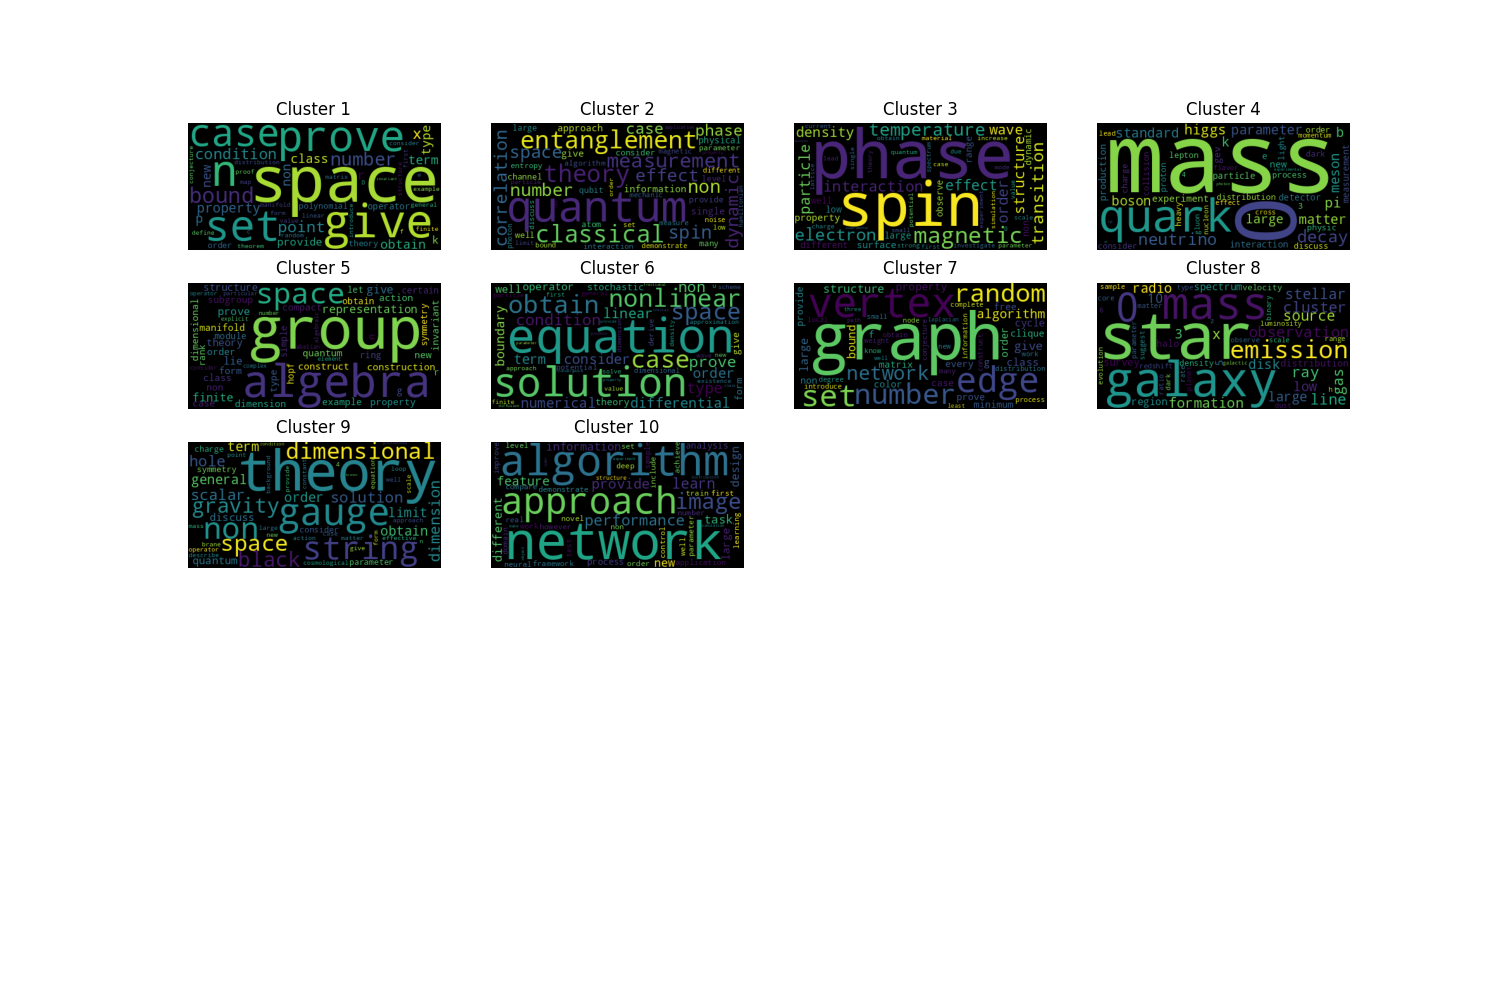

In [ ]:
plot_word_clouds(clustered_abstracts_top50)


### 3D Scatterplot Visualization

Dimensionality Reduction for Cluster Visualization
To visualize the clusters, implemented a dimensionality reduction approach using PCA from sklearn.decomposition. By reducing the 100 features to 3 principal components, we enable the creation of a labeled scatterplot for cluster inspection, making the data more interpretable for visualization purposes.

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
!pip install ipympl
%matplotlib widget

In [ ]:
abstracts

id                    submitter  \
0            0804.0629                  Boaz Tsaban   
1            0908.3353      Fabio Giuseppe Pusateri   
2     quant-ph/0304129                     Mardoyan   
3           1605.06142               Nadine Fischer   
4     cond-mat/0602014  Anna Morozovska Nickolaevna   
...                ...                          ...   
4995        2109.11976              Michael Mueller   
4996         1010.3444               Michael K\"ohl   
4997         1406.7261                Pedro Gir\~ao   
4998        2112.09876                   Qinzhi Xia   
4999        cs/0306015       Sudebkumar Prasant Pal   

                                                authors  \
0         Arkadius Kalka, Mina Teicher, and Boaz Tsaban   
1                                        Fabio Pusateri   
2         L.G. Mardoyan, L.S. Petrosyan, H.A. Sarkisyan   
3     Nadine Fischer, Stefan Prestel, Mathias Ritzma...   
4                     A. N. Morozovska and E.A. Eliseev   
...                                                 ...   
4995                         Do Kester, Michael Mueller   
4996  Christoph Zipkes, Lothar Ratschbacher, Stefan ...   
4997  Jo\~ao L. Costa, Pedro M. Gir\~ao, Jos\'e Nat\...   
4998          L. G. Liao, Q. Z. Xia, J. Cai, and J. Liu   
4999  P. H. D. Ramakrishna, Sudebkumar Prasant Pal, ...   

                                               comments  \
0     Final version, accepted to Advances in Applied...   
1                                              19 pages   
2                                    8 pages, 5 figures   
3                                                   NaN   
4                                   25 pages, 7 figures   
...                                                 ...   
4995           To be published in Astronomy & Computing   
4996                                   ICAP proceedings   
4997  48 pages, 5 figures; v2: some presentation cha...   
4998                                  9 pages,4 figures   
4999                               13 pages, no figures   

                                          journal-ref  \
0     Advances in Applied Mathematics 49 (2012) 57-76   
1                                                 NaN   
2                                                 NaN   
3                                                 NaN   
4                                                 NaN   
...                                               ...   
4995                                              NaN   
4996                                              NaN   
4997                             Ann. PDE (2017) 3: 8   
4998                                              NaN   
4999                                              NaN   

                                 doi  \
0          10.1016/j.aam.2012.03.001   
1                                NaN   
2         10.1103/PhysRevA.68.014103   
3     10.1140/epjc/s10052-016-4429-6   
4                                NaN   
...                              ...   
4995                             NaN   
4996  10.1088/1742-6596/264/1/012019   
4997       10.1007/s40818-017-0028-6   
4998                             NaN   
4999                             NaN   

                                               abstract  \
0     [march, 2004, anshel, anshel, goldfeld, lemieu...   
1     [consider, interface, incompressible, inviscid...   
2     [spherical, wave, charge, dyon, bound, rectang...   
3     [first, public, implementation, antenna, qcd, ...   
4     [modify, landau, khalatnikov, approach, polar,...   
...                                                 ...   
4995  [bayesicfitting, comprehensive, general, purpo...   
4996  [recent, year, ultracold, atom, emerge, except...   
4997  [third, part, trilogy, dedicate, following, gi...   
4998  [investigate, theoretically, photoelectron, mo...   
4999  [several, numerical, compute, approximate, zer...   

                                              report-no  \
0      

In [ ]:
def clusters_3d_scatterplot(abstracts_feats:np.ndarray, clustering:KMeans, abstracts:pd.DataFrame):
    """
    Generate a 3D Scatterplot of the best K-Means clustering
    model using PCA

    Parameters
    ----------
    abstracts_feats : np.ndarray
        Feature matrix for abstracts data
    clustering:KMeans
        Instance of KMeans class
    abstracts:pd.DataFrame
        Dataframe containing a column
        'abstract'
    """
    pca_instance = PCA(n_components=3)
    red_pca_mat = pca_instance.fit_transform(abstracts_feats)

    k_labels=clustering.labels_

    abstracts['k_index_cluster'] = k_labels
    cluster_5_words = []
    for k in range(clustering.n_clusters):
      k_abstracts = abstracts[abstracts['k_index_cluster'] == k]['abstract']
      words_chain=chain.from_iterable(k_abstracts)
      word_dict={}
      for word in words_chain:
        if word in word_dict:
            word_dict[word]+=1
        else:
            word_dict[word]=1

      most_occurring_words = sorted(word_dict.items(), key=lambda x: x[1], reverse=True)[:5]
      cluster_5_words.append(' '.join(five_word[0] for five_word in most_occurring_words))

    fig_size = plt.figure(figsize=(15,15))
    subplt = fig_size.add_subplot(projection='3d')
    scatter=subplt.scatter(red_pca_mat[:,0], red_pca_mat[:,1], red_pca_mat[:,2], c=k_labels, cmap="turbo")


    subplt.set_xlabel('X')
    subplt.set_ylabel('Y')
    subplt.set_zlabel('Z')

    subplt.set_xlim([-0.18, 0.18])
    subplt.set_ylim([-0.18, 0.18])
    subplt.set_zlim([-0.18, 0.18])

    subplt.set_title("KMeans Clustering 3D Plot", fontsize=10)
    subplt.set_xlabel("feat 1", fontsize=8)
    subplt.set_ylabel("feat 2", fontsize=8)
    subplt.set_zlabel("feat 3", fontsize=8)

    lg_label = [f"Cluster with topics: {words}" for i, words in enumerate(cluster_5_words)]
    fig_size.legend(handles=scatter.legend_elements()[0], labels=lg_label, loc='upper right')

    plt.show()

Visualizing scatter plot:

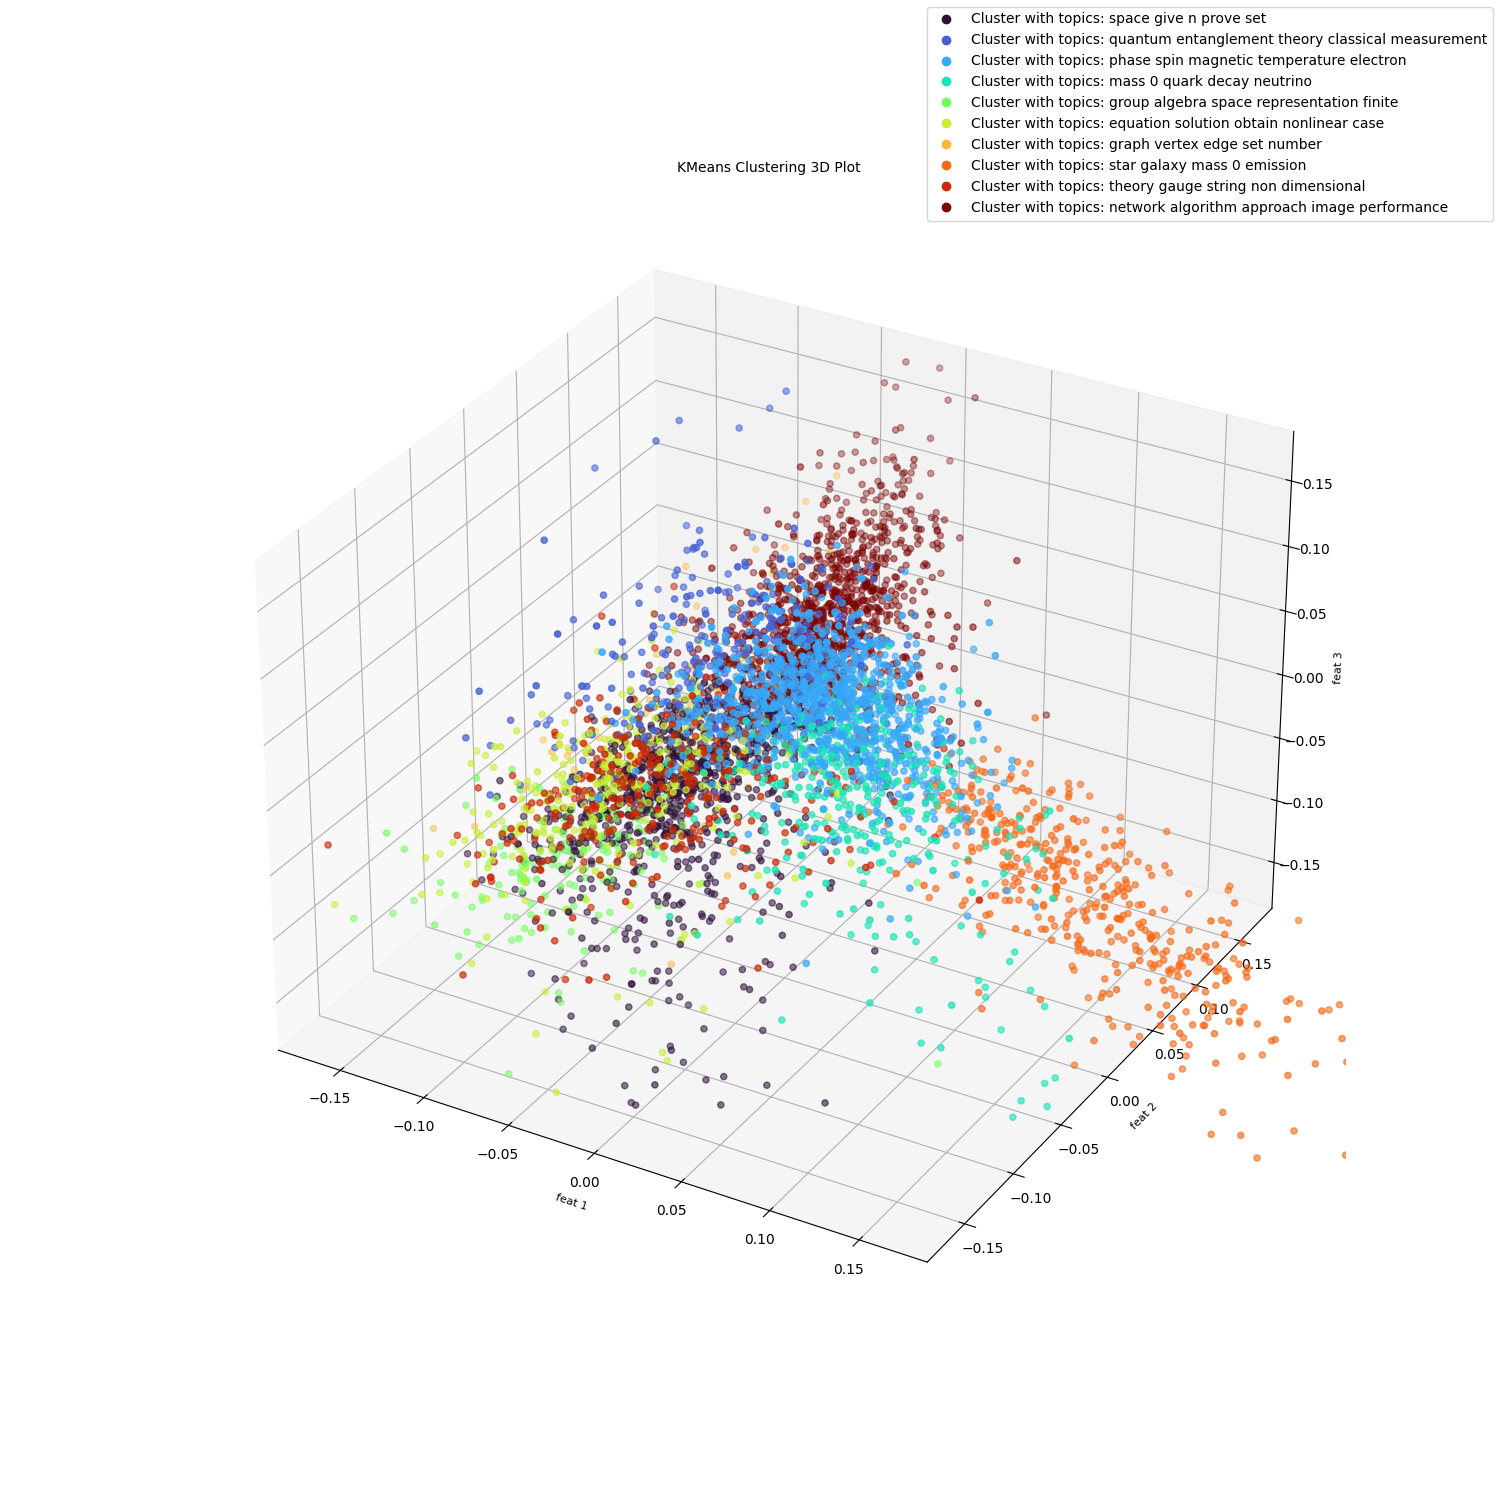

In [ ]:
clusters_3d_scatterplot(red_tfidf_feats, best_tfidf_clustering, processed_abstracts)





###  Major Scientific Topics

Deduction of Major Scientific Topics from Word Clouds




*   Cluster 1: Words like space, set, bound, case, prove, n, x realtes to the field of mathematics, possibly realted to Set theory.

*   Cluster 2: Words like entanglement, quantam, number, theory, phase ,effecr realtes to the field of physics, possibly realted to Quantum physics.

*    Cluster 3: Words like phase, spin, magnetic, temperature, electron ,effecr realtes to the field of physics, possibly realted to Magnetism.

*   Cluster 4: Words like mass, quark, matter, neutrino, meson ,decay realtes to the field of physics, possibly realted to Subatomic Particles.

*   Cluster 5: Words like space, group, algebra, symmetry, theory realtes to the field of mathematics, possibly realted to Algebra.

*    Cluster 6: Words like non-linear, equation, case, solution, prove, operator realtes to the field of mathematics, possibly realted to non-linear equations.

*   Cluster 7: Words like graph, number, network, edge, vertex, algorithm realtes to the field of computer science, possibly realted to computer networks.

*    Cluster 8: Words like star, emission, galaxy, mass, source, gas, formation realtes to the field of astronomy, possibly realted to star formation.

*   Cluster 9: Words like theory, dimensional, string, space, guage, gravity to the field of physics, possibly realted to string theory.

*    Cluster 10: Words like algorithm, approach, network, feature, image, performane, task,learning realtes to the field of computer science, possibly realted to Machine Learning.





